# Discussion Figure --- river contributions in North Water polynya / Pikialasorsuaq

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from matplotlib.colors import ListedColormap
import xarray as xr
from scipy.interpolate import interp1d

%matplotlib inline

#### Parameters:

In [4]:
# Domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax - imin
jsize = jmax - jmin

month = 8

# Results folders:
folder_ref  = '/data/brogalla/run_storage/Mn-reference-202110/'
folder_glac = '/data/brogalla/run_storage/river-glacial-202112/'
folder_cont = '/data/brogalla/run_storage/river-continental-202112/'

land_color = '#a9a7a2'

# Color maps:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(171/N, 1, N)
vals_cont[:, 1] = np.linspace(92/N, 1, N)
vals_cont[:, 2] = np.linspace(41/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(8/N, 1, N)
vals_glac[:, 1] = np.linspace(115/N, 1, N)
vals_glac[:, 2] = np.linspace(180/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

In [5]:
# Coordinates and lines for delineating the North Open Water polynya region
NOW_lons = np.array([-79, -75, -70, -67, -67, -70, -72.8, -75, -78, -78.5, -79.2, -79])
NOW_lats = np.array([74.6, 75.2, 75.4, 75.8, 76, 76, 78.2, 78.2, 76.5, 75.5, 74.8, 74.6])

t = np.arange(len(NOW_lons))
ti = np.linspace(0, t.max(), 10 * t.size)

xi = interp1d(t, NOW_lons, kind='cubic')(ti)
yi = interp1d(t, NOW_lats, kind='cubic')(ti)

#### Load files:

In [6]:
# Meshmasks
mask          = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask         = np.array(mask.variables['tmask'])
land_mask     = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 
tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]
lon_ANHA12    = np.array(mask.variables['nav_lon'])
lat_ANHA12    = np.array(mask.variables['nav_lat'])
e3t           = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e1t_base      = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base      = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
hdept         = np.array(mask.variables['hdept'])[0,imin:imax,jmin:jmax]

In [7]:
ref     = nc.Dataset('/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-2002_20211012/ANHA12_EXH006_2002_monthly.nc','r')
lon_sub = np.array(ref.variables['nav_lon'])
lat_sub = np.array(ref.variables['nav_lat'])
depth   = np.array(ref.variables['deptht'])

#### Functions:

In [8]:
def load_results():
    
    file = f'climatology.nc'
    path_ref  = f'{folder_ref}/{file}'
    path_glac = f'{folder_glac}/{file}'
    path_cont = f'{folder_cont}/{file}'
    
    with xr.open_dataset(f'{path_ref}') as monthly_ref:
        dmn_ref = monthly_ref['dissolmn'].values[:,0,:,:,:]
    
    with xr.open_dataset(f'{path_glac}') as monthly_glac:
        dmn_glac = monthly_glac['dissolmn'].values[:,0,:,:,:]
        
    with xr.open_dataset(f'{path_cont}') as monthly_cont:
        dmn_cont = monthly_cont['dissolmn'].values[:,0,:,:,:]
    
    return dmn_ref, dmn_glac, dmn_cont

In [ ]:
def calculate_depth_weighted(dMn, levels=(0,16)):
    
    dMn_weighted     = dMn[levels[0]:levels[1],:,:]*e3t[levels[0]:levels[1],:,:]
    
    # bottom depth (in case of regions shallower than levels[1]: 
    depth_top        = np.zeros_like(mesh_bathy[imin:imax,jmin:jmax])
    if levels[0] != 0:
        depth_top[mesh_bathy[imin:imax,jmin:jmax] > depth_model[levels[0]-1]] = depth_model[levels[0]-1] # top of layer is not the surface
    depth_bottom     = np.copy(mesh_bathy[imin:imax,jmin:jmax])
    depth_bottom[depth_bottom > depth_model[levels[1]-1]] = depth_model[levels[1]-1]
    delta_depth      =  depth_bottom - depth_top
                 
    # calculate average:
    dMn_weighted_ave = np.sum(dMn_weighted, axis=0) / delta_depth
    
    return dMn_weighted_ave

#### Calculations:

In [9]:
dmn_ref, dmn_glac, dmn_cont = load_results()

In [10]:
# Depth-weighted proportion:
index_bottom = 17
depth_bottom = np.copy(hdept) # sum from surface to sea floor
depth_bottom[depth_bottom > depth[index_bottom]] = depth[index_bottom] # sum over depth from surface to index bottom
depth_bottom[depth_bottom == 0] = np.nan # where ocean depth is zero, replace depth with NaN

monthly_depths = np.tile(e3t, (12,1,1,1))

In [11]:
# monthly Mn addition (month, x, y)
monthly_Mn_content  = (dmn_ref[:,0:index_bottom,:,:] * \
                       monthly_depths[:,0:index_bottom,:,:]).sum(axis=(1)) / depth_bottom

# monthly glacial Mn addition (month, x, y)
monthly_glacial_Mn_content  = (((dmn_glac[:,0:index_bottom,:,:] * \
                       monthly_depths[:,0:index_bottom,:,:]).sum(axis=(1)) / depth_bottom) - monthly_Mn_content)

proportion_glacial = monthly_glacial_Mn_content * (100/(1.5-1)) / monthly_Mn_content

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Amount of Mn in the glacial experiment minus the amount of Mn in the reference experiment in a grid cell gives the glacial contribution in mol/L to a grid cell. Dividing this by the actual Mn content shows the actual proportion of Mn at that grid cell is from the glaciers.

#### Figures

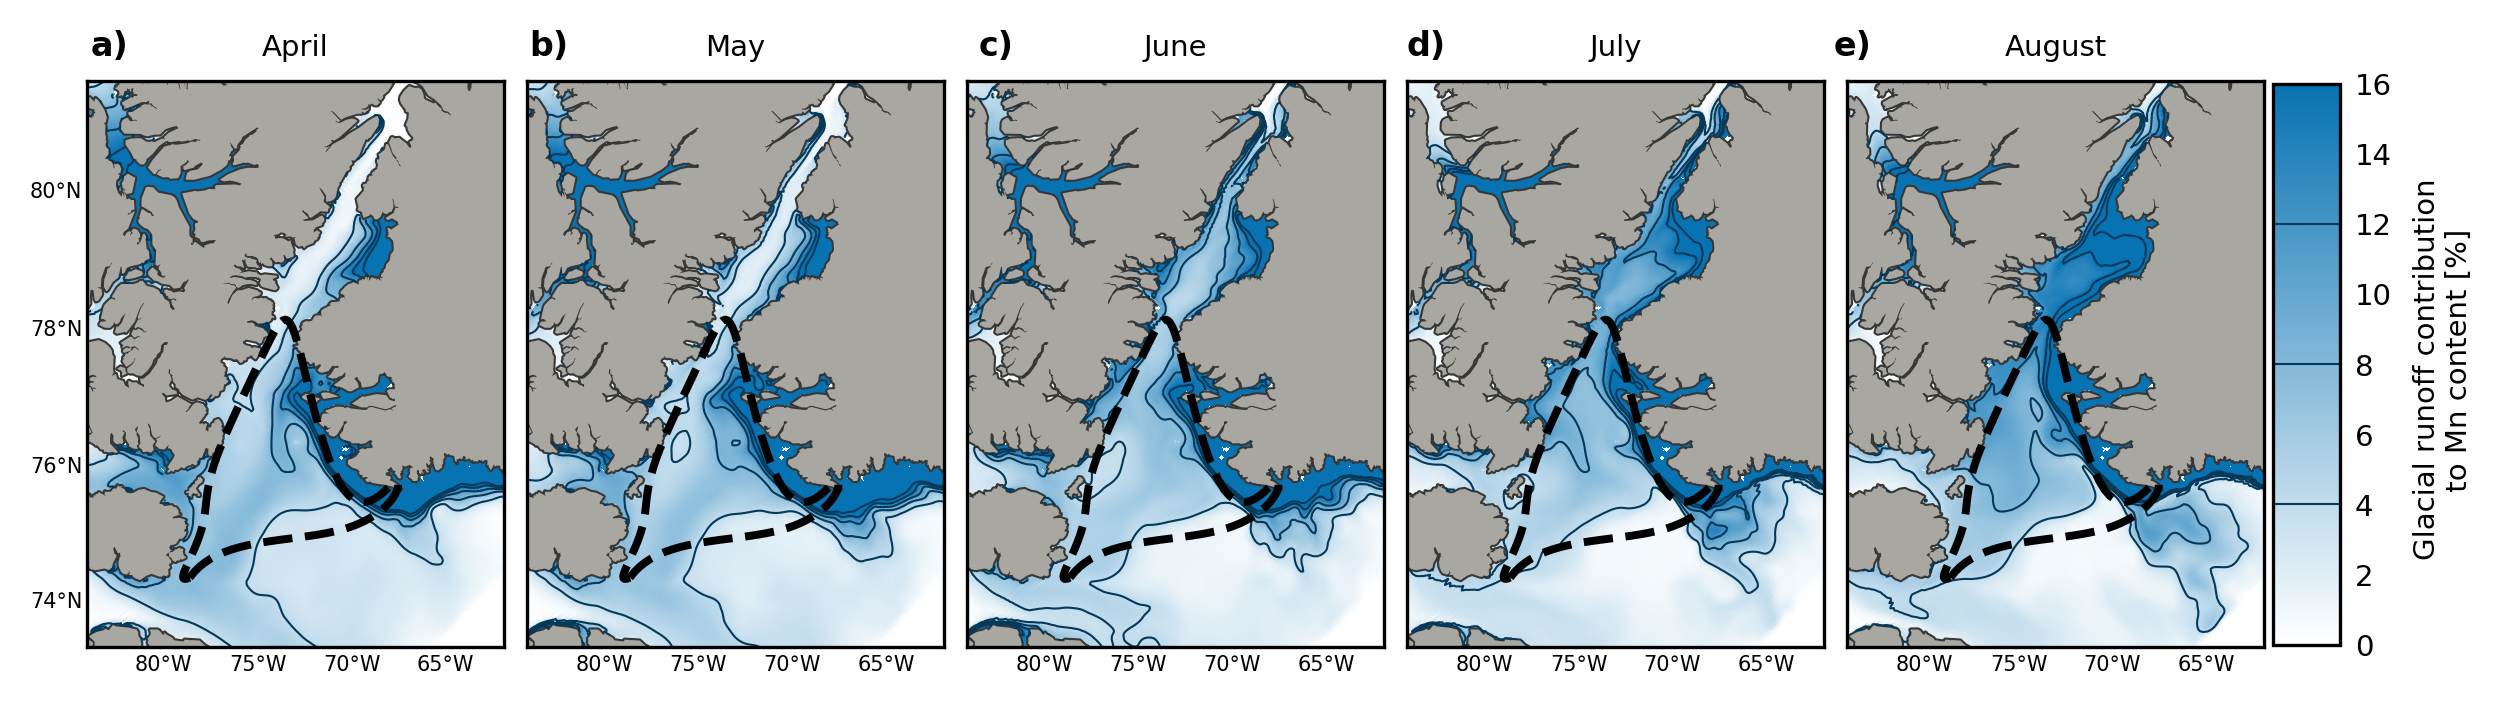

In [17]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/polynya.pickle','rb'))

months_ind = [3,4,5,6,7] 
months     = ['April', 'May', 'June', 'July', 'August']

x_model, y_model = proj1(lon_sub, lat_sub)
x_NOW  , y_NOW   = proj1(xi, yi)

# loop over each of the panels
for i, axis in enumerate(ax.ravel()):
    # Coloured contours:
    CS1 = axis.pcolormesh(x_model, y_model, proportion_glacial[months_ind[i],:,:], \
                          vmin=0, vmax=16, cmap=glac_cmap)
    axis.plot(x_NOW, y_NOW, '--k', linewidth=1.9, zorder=3)
    axis.set_title(months[i], fontsize=7)
    
    glac = axis.contour(x_model, y_model, proportion_glacial[months_ind[i],:,:], \
                        levels=[4,8,12,16,20], \
                        vmin=0, vmax=10, colors='#04395a', linewidths=0.5)
    
# add text labels:
fig.text(0.030, 0.775, 'a)', fontsize=8, weight='bold');
fig.text(0.225, 0.775, 'b)', fontsize=8, weight='bold');
fig.text(0.425, 0.775, 'c)', fontsize=8, weight='bold');
fig.text(0.615, 0.775, 'd)', fontsize=8, weight='bold');
fig.text(0.805, 0.775, 'e)', fontsize=8, weight='bold');

# Colorbars:
cbaxes1 = fig.add_axes([1.0, 0.25, 0.03, 0.5]) 
CBar1   = plt.colorbar(CS1, ax=ax[0], cax=cbaxes1) 
CBar1.add_lines(glac)
CBar1.ax.tick_params(axis='y', length=0, labelsize=7)
CBar1.ax.yaxis.get_offset_text().set(size=7)
CBar1.set_label('Glacial runoff contribution \n to Mn content [%]', labelpad=5, fontsize=7)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202206/D7-NOW.jpg', bbox_inches='tight', dpi=300)